# 10_fold Random distribution of data set- Accelerometer

In [16]:
import glob
import pandas as pd
import numpy as np
import os, sys
import collections
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.decomposition import PCA

C:\Users\BKY\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from numba.typed import List
from numba import jit, njit, vectorize

In [4]:
sample_rate = 50  # number of observation per second based on dataset documentation(150 samples in 3 second)

sliding_size = int((1/3) * sample_rate)  # number of skipped datapoints to start next window
print(sliding_size)

16


# Feature sets

In [5]:
@njit()
def mean_crossing_rate(col):
    # col = np.array(values)
    normalized = col - col.mean()  # to make elements of array possitive or negetive
    return ((normalized[:-1] * col[1:]) < 0).sum()  # Zero-Crossing_rate

@njit()
def iqr(window):  # inter-quartile range
    Q1 = np.median(window[:len(window)//2])  # First quartile (Q1) 
    Q3 = np.median(window[len(window)//2:])  # Third quartile (Q3) 
    IQR = Q3 - Q1 # Interquartile range (IQR) 
    return(IQR) 
@njit()
def calc_sma_for_window(data):
    return np.sum(data) / len(data)  
@njit()
def get_min(x):
    m = np.min(x)
    return m
@njit()
def get_max(x):
    m = np.max(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_var(x):
    m = np.var(x)
    return m
@njit()
def get_mean(x):
    m = np.mean(x)
    return m
@njit()
def get_sum(x):
    m = x.sum()
    return m 
@njit()
def get_median(x):
    m = np.median(x)
    return m 
@njit()
def get_std(x):
    m = np.median(x)
    return m 



In [6]:
def Energy(frame):
    return sum( [ abs(x)**2 for x in frame ] ) / len(frame)

In [7]:
def FS3(window):# mean, std,max,min and zero-crossing-rate
    win = np.array(window[:-1])
    features = []
    
    features.append(get_mean(win))
    features.append(get_median(win))
    features.append(get_var(win))
    features.append(get_std(win))
    features.append(get_min(win))
    features.append(get_max(win))
    features.append(get_sum(win))
    mean_crossing = [mean_crossing_rate(window.iloc[:, i].values) for i in range(window.shape[1] - 1)]
    features.append(np.array(mean_crossing))
    IQR = iqr(win)
    features.append(np.array(IQR))
    energy_measure = Energy(win)
    features.append(np.array(energy_measure))
 

    features = np.hstack(features).tolist()

    label = window.iloc[:, -1].mode()[0]  ## select the most frequent label as the label of the window
    features.append(label)
    return features

In [8]:
def windowing_dataset(dataset, win_size, feature_extraction_function, subject_id, overlap=False):
    windowed_dataset = []
    win_count = 0
    if overlap:
        step_size = sliding_size  # for Overlapping technique
    else:
        step_size = win_size  # for Non-overlapping technique

    for index in range(0, dataset.shape[0], step_size):
        start = index
        end = start + win_size
        # to assure all of windows are equal in size
        if (end <= dataset.shape[0]):
            window = dataset.iloc[start:end, :].reset_index(drop=True)
            win_count = win_count + 1
            features = feature_extraction_function(window)

            windowed_dataset.append(features)

    final = pd.DataFrame(windowed_dataset)
    final.insert(0, 'group', subject_id)  # to use in Subject CV
    return final

In [9]:
def Preprocessing(dataset_path, overlapping):
    feature_function = FS3
    win_size = 3
    #for win_size in win_sizes:
    print("Start for win size {}".format(win_size))
    datapoints_per_window = int(win_size * sample_rate)

    #for feature_function in features_functions:

    print(feature_function.__name__)

    windowed_dataset = []

    for subject in range(1,18):
        file_path = dataset_path + '\subject{0}_ideal.csv'.format(subject)
        acc_cols = []
        for i in range(2, 117, 13):# indices of accelarations
            indices = list(range(i, i + 3))
            acc_cols.extend(indices)

        acc_cols.append(119)  # label index

        tmp_db = pd.read_csv(file_path, header=None, usecols=acc_cols, sep='\t')
        tmp_db.columns = list(range(tmp_db.shape[1]))  # re-index the columns

        transformed_db = windowing_dataset(tmp_db, datapoints_per_window, feature_function, subject,
                                                   overlap=overlapping)

        windowed_dataset.append(transformed_db)

    final_dataset = pd.DataFrame()
    print("Features")
    final_dataset = final_dataset.append(windowed_dataset, ignore_index=True)
    return final_dataset
   

In [10]:
def subject_cross_validation(X, Y, groups, classifier):
    f1 = []
    logo = LeaveOneGroupOut()
    i = 0
    for train_index, test_index in logo.split(X, Y, groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        i += 1
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        f = f1_score(y_true=y_test, y_pred=y_pred, average='micro')
        
        print(classifier,' Model-',i ,' -',' f1 score: ', f)
       
        f1.append(f)
    return np.mean(f1)

In [11]:
# cv_strategy can be iid or sbj for k-fold cv and subject cv respectively

def apply_classifiers(dataset, models, cv_strategy):
    results = dict()
    win_size = float(3)
    print('window_size = ', win_size,' sec')

    dataset = dataset
    groups = dataset['group']
    X = dataset.iloc[:, 1:-1].values
    
    pca = PCA(n_components=30, random_state = 42)
    pca.fit(X)
    X = pca.transform(X)
    
    Y = dataset.iloc[:, -1].values


    for model_name, model in models.items():
        f1 = 0

        f1 = cross_val_score(estimator=model, X=X, y=Y,
                                cv=KFold(n_splits=10, shuffle=True, random_state=1), scoring='f1_micro',
                                n_jobs=-1).mean()

        if win_size in results:
            results[win_size].append(f1)
        else:
            results[win_size] = [f1]

        

        results = collections.OrderedDict(sorted(results.items()))

        final = []
        col = list(models.keys())
        col.insert(0, "window-size")
        final.append(col)
        for k, v in results.items():
            tmp = []
            tmp.append([k])
            tmp.append(v)
            flattened = [val for sublist in tmp for val in sublist]
            final.append(flattened)
    final = pd.DataFrame(final)   
    return final

In [12]:
models = {'DT': DecisionTreeClassifier(criterion='entropy'), 'NB': GaussianNB(),
          'NCC': NearestCentroid(), "KNN": KNeighborsClassifier(n_neighbors=3),
          'RF': RandomForestClassifier(n_estimators=40,criterion = 'entropy', random_state=42, n_jobs=-1)}

In [13]:
%%time
dataset_csv_path = r"D:\projec\proj\data"

overlapping = 1

df = Preprocessing(dataset_path=dataset_csv_path, overlapping=bool(int(overlapping)))

df.head(10)

Start for win size 3
FS3
Features
Wall time: 5min 34s


,group,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,1,-1.633620,-1.00435,30.094853,-1.00435,-13.572,13.123,-6815.463652,51.0,73.0,...,2.593908,3.921385,91.174770,4.905180,6.950782,102.991179,2.137176,10.651568,1.0,1
1,1,-1.639097,-1.06545,30.104036,-1.06545,-13.572,13.123,-6838.311812,54.0,82.0,...,2.855557,4.288218,89.176574,4.811995,6.125328,105.046067,2.107242,9.677228,1.0,1
2,1,-1.661861,-1.20775,30.313215,-1.20775,-13.572,13.123,-6933.284960,55.0,84.0,...,3.179011,4.984253,91.011443,5.429592,7.113794,102.195931,2.257098,8.337835,1.0,1
3,1,-1.715638,-1.24765,29.776745,-1.24765,-13.547,10.304,-7157.641101,27.0,90.0,...,3.262519,4.449573,90.943000,5.761267,8.118373,101.553044,2.343028,6.122427,1.0,1
4,1,-1.762650,-1.17900,29.704331,-1.17900,-13.547,12.127,-7353.774895,22.0,95.0,...,2.882481,3.759509,89.543313,5.228089,7.611502,102.890095,2.218564,7.288485,1.0,1
5,1,-1.867453,-1.14215,30.132488,-1.14215,-16.693,13.038,-7791.014918,37.0,90.0,...,3.190035,3.793951,92.778907,5.139430,8.719024,104.971318,2.267715,10.694123,1.0,1
6,1,-1.979606,-1.18770,29.463555,-1.18770,-16.693,13.038,-8258.915145,42.0,76.0,...,3.413811,3.411228,92.333098,5.080037,7.986029,103.833455,2.306007,10.382769,1.0,1
7,1,-2.125250,-1.32565,29.300628,-1.32565,-16.693,18.240,-8866.543711,47.0,54.0,...,3.959646,5.454866,90.466802,4.931867,7.836691,105.831842,2.330283,9.540168,1.0,1
8,1,-2.284407,-1.34015,29.472833,-1.34015,-18.348,18.240,-9530.548005,51.0,56.0,...,4.767428,5.541494,95.926050,5.450808,9.022392,102.423261,2.511480,8.572841,1.0,1
9,1,-2.442704,-1.37980,28.318927,-1.37980,-18.348,18.240,-10190.963090,53.0,58.0,...,4.336226,5.366557,91.578048,4.842937,9.462464,106.798786,2.395293,10.053509,1.0,1


In [14]:
%%time
dataset = df

apply_classifiers(dataset=dataset, models=models, cv_strategy='iid')

window_size =  3.0  sec
Wall time: 7min 5s


,0,1,2,3,4,5
0,window-size,DT,NB,NCC,KNN,RF
1,3,0.966395,0.938271,0.324162,0.973815,0.987956


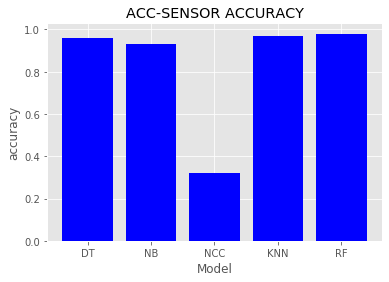

In [19]:
x = ['DT', 'NB', 'NCC', 'KNN','RF']
accuracy = [0.96,0.93,0.32,0.97,0.98]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='blue')
plt.xlabel("Model")
plt.ylabel("accuracy")
plt.title("ACC-SENSOR ACCURACY")

plt.xticks(x_pos, x)

plt.show()